In [1]:
# !pip install git+https://github.com/ChristianTremblay/pyhaystack.git

In [4]:
import os
import sys
import time
import json
import pprint
import warnings
import numpy as np
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt

import pyhaystack
from hszinc import jsondumper

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

def grid_to_pandas(g):
    d = json.loads(jsondumper.dump_grid(res))
    
    # parse columns (assuming c[0] is timestamp index)
    cols = ['date_time'] + [c['channelName'].replace('s:', '') \
                            for c in d['cols'][1:]]
    
    # parse values
    val = []
    for r in d['rows']:
        val.append([c.replace('t:', '').replace('n:', '').split(' ')[0] \
                    for c in r.values()])
        
    # convert to pandas
    df = pd.DataFrame(val, columns=cols)
    df = df.set_index('date_time')
    df.index = pd.to_datetime(df.index)
    df = df.apply(lambda x: pd.to_numeric(x))
    return df

### Configure

In [12]:
# read credentials
with open(os.path.join(root, '..', 'communication', 'skyspark.txt')) as f:
    creds = json.loads(f.read())
    
# start_time = '2023-01-01'
start_time = '2023-05-01'
final_time = '2023-05-09'
ts = '15min'

### Download Skyspark

In [13]:
# establish session
session = pyhaystack.connect(implementation='skyspark',
                             uri='https://siku.lbl.gov/',
                             project='flexlab',
                             username=creds['u'],
                             password=creds['p'])

# Documentation for API: https://haxall.io/doc/docHaxall/AxonUsage.html#dict

# cmd = 'readAll(point and wkh_PV).hisRead(today).hisRollup(avg, 5min)'
# cmd = 'readAll(point and wkh_PV).hisRead(lastMonth).hisRollup(avg, 5min)'
cmd = f'readAll(point and wkh_PV).hisRead({start_time}..{final_time}).hisRollup(avg, {ts})'
# cmd = 'readAll(point and wkh_PV).hisRead(2023-04-01).hisRollup(avg, 5min)'
res = session.get_eval(cmd).result
data = grid_to_pandas(res)

### Merge and Store

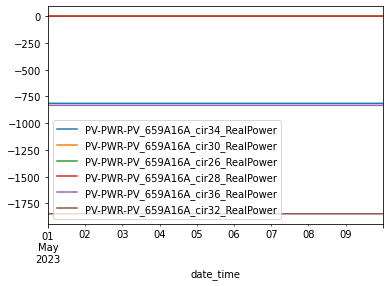

In [14]:

data[[c for c in data.columns if 'RealPower' in c]].plot()
plt.show()